In [1]:
import json
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import seaborn as sns
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'axes.spines.bottom': False,
      'axes.spines.left': False,
      'axes.spines.right': False,
      'axes.spines.top': False,}
plt.rcParams.update(rc)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
DATA_PATH = '../../data/processed/data.json'
VISUALIZATION_FOLDER = '../../visualizations/ingredients/'

In [4]:
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)
keys = list(data.keys())

In [5]:
first_10 = keys

In [6]:
colors = {
    'Africa': 'green',
    'Asia': 'red',
    'Brazil': 'yellow',
    'United Kingdom': 'blue',
    'Caribbean': 'yellow',
    'Central and South America': 'yellow',
    'China': 'red',
    'Cuba': 'yellow',
    'Dominican Republic': 'yellow',
    'Ethiopia': 'green',
    'Europe': 'blue',
    'Philippines': 'red',
    'France': 'blue',
    'Germany': 'blue',
    'Haiti': 'yellow',
    'Hawaii': 'purple',
    'India': 'orange',
    'Italy': 'blue',
    'Jamaica': 'yellow',
    'Japan': 'red',
    'Kenya': 'green',
    'Korea': 'red',
    'Laos': 'red',
    'Lebanon': 'orange',
    'Mediterranean': 'blue',
    'Mexico': 'yellow',
    'Middle East': 'orange',
    'North America': 'purple',
    'Persia': 'orange',
    'Peru': 'yellow',
    'Poland': 'blue',
    'Puerto Rico': 'yellow',
    'South Africa': 'green',
    'Southern United States': 'purple',
    'Southwestern United States': 'purple',
    'Sweden': 'blue',
    'Taiwan': 'red',
    'Thailand': 'red',
    'Venezuela': 'yellow',
    'Vietnam': 'red',
    'West Africa': 'green'
}

countries_from_colors = defaultdict(list)

for country, color in colors.items():
    countries_from_colors[color].append(country)

## Binarizing ingredients

In [7]:
ingredient_annotations = [recipe['ingredient_annotations'] for recipe 
                            in data.values()]

unique_ingredients = set()

for ingredients in ingredient_annotations:
    for ingredient in ingredients:
        unique_ingredients.add(ingredient)

# make a binarized encoding of all ingredients
recipes = list(data.keys())
ingredient_columns = dict()

for ingredient in unique_ingredients:
    ingredient_columns[ingredient] = np.array([1 if ingredient in data[recipe]['ingredient_annotations'] else 0 for recipe in recipes])

df = pd.DataFrame(ingredient_columns, index=recipes)

In [8]:
# frequency of ingredients in all recipes
all_ingreds = []
for val in data.values():
    all_ingreds.extend(val["ingredient_annotations"])

ingred_counter = Counter(all_ingreds)

most_common = [ingr for ingr, _ in sorted(list(ingred_counter.items()), key=lambda x: x[1], reverse=True)]

# don't include the 15 most common ingredients -- This we found improved the PCA
for ingr in most_common[:15]:
    del df[ingr]

## Distribution of ingredients

In [9]:
list_ingred_counter = sorted(list(ingred_counter.items()), key=lambda x: x[1], reverse=True)

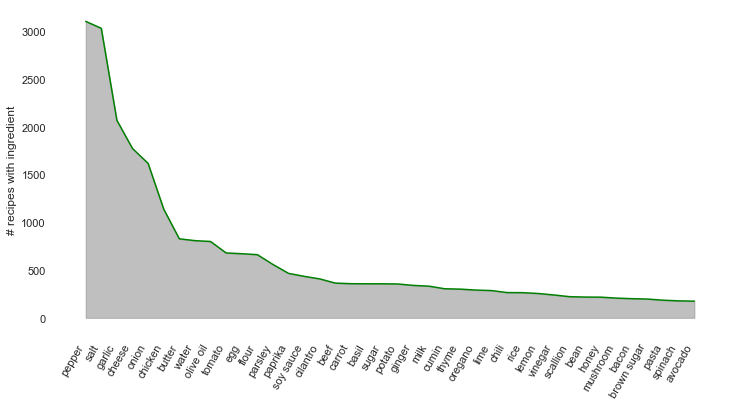

In [50]:
fig = plt.figure(figsize=(12,6))

ingr, num = list(zip(*list_ingred_counter[:40]))

plt.fill_between(ingr, num, color='grey', alpha=0.5)
plt.plot(ingr,num, color='green')
plt.xticks(rotation=60, ha='right')
plt.ylabel('# recipes with ingredient')

plt.savefig(VISUALIZATION_FOLDER + 'ingredient_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## PCA of ingredients

In [15]:
# PCA with 2 components, for visualisation purposes
pca_recipes = PCA(n_components=2)

df_PCA= pd.DataFrame(data = pca_recipes.fit_transform(df), 
                     index=recipes)

# using the clusters computed by KMeans
#PCA_df['cluster'] = res

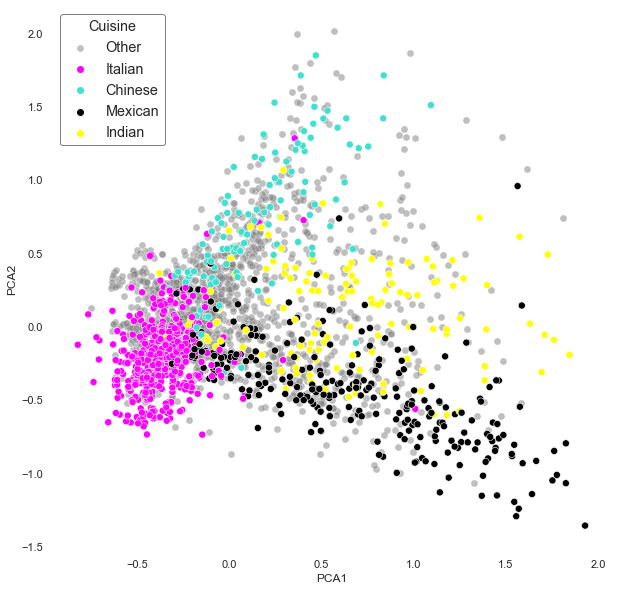

In [51]:
tags_to_use = {'Italian',
               'Chinese',
               'Mexican',
               'Indian'}

colors_to_use = {
    'Italian': 'magenta',
    'Chinese': 'turquoise',
    'Mexican': 'black',
    'Indian': 'yellow'

}

df_PCA['location'] = [
    list(
        tags_to_use.intersection(data[ind]['tags'])
    )[0]

    if len(tags_to_use.intersection(data[ind]['tags'])) == 1
    
    else 'Other'

    for ind in df_PCA.index
]

plt.figure(figsize=(10, 10))
#plt.rcParams['font.family'] = 'Computer Modern'

# Filter the dataframe to separate 'Other' from the rest of the data
other_data = df_PCA[df_PCA['location'] == 'Other']
colored_data = df_PCA[df_PCA['location'] != 'Other']

sns.scatterplot(x=other_data[0], y=other_data[1], color='grey', label='Other', alpha=0.5, s=50)
sns.scatterplot(x=colored_data[0], y=colored_data[1], hue=colored_data['location'], palette=colors_to_use, s=50)

# Add legend
plt.legend(fontsize='large', framealpha=1, facecolor='white', edgecolor='gray', title="Cuisine", title_fontsize='large')
#plt.title('Principal Component Analysis of\ningredients with selected tags highlighted')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig(VISUALIZATION_FOLDER + 'PCA.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

## Clustering of ingredients

In [17]:
amount_clusters = 4

kmeans = KMeans(n_clusters = amount_clusters, random_state = 10)
res = kmeans.fit_predict(df)

C:\Users\Bruger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
cluster_colors = {
    0: 'green',
    1: 'orange',
    2: 'blue',
    3: 'red'
}

In [19]:
df_clusters = df.copy()
df_clusters['cluster'] = res
df_PCA['cluster'] = res

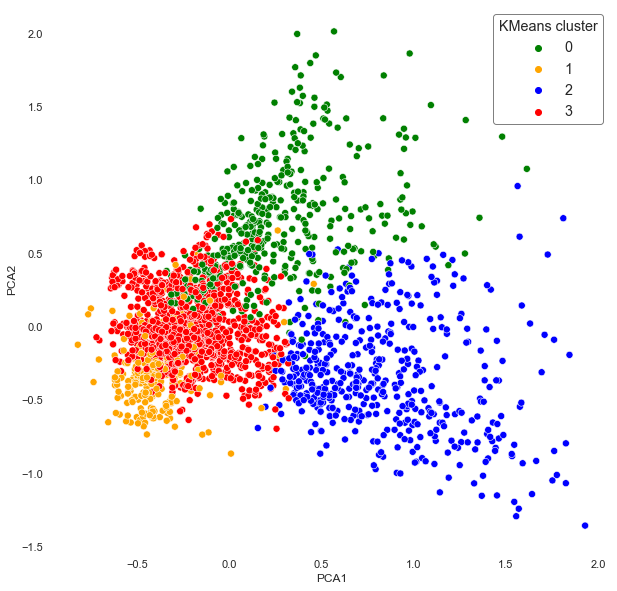

In [52]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x=df_PCA[0], y=df_PCA[1], hue=df_PCA['cluster'], palette=cluster_colors, s=50)

# Add legend
plt.legend(title='KMeans cluster', framealpha=1, facecolor='white', edgecolor='gray', fontsize='large', title_fontsize='large')
#plt.title('Principal Component Analysis of\ningredients with selected tags highlighted')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.savefig(VISUALIZATION_FOLDER + 'PCA_clusters.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


#### Mapping

In [21]:
print(sns.color_palette('husl', 9).as_hex())

['#f77189', '#d58c32', '#a4a031', '#50b131', '#34ae91', '#37abb5', '#3ba3ec', '#bb83f4', '#f564d4']


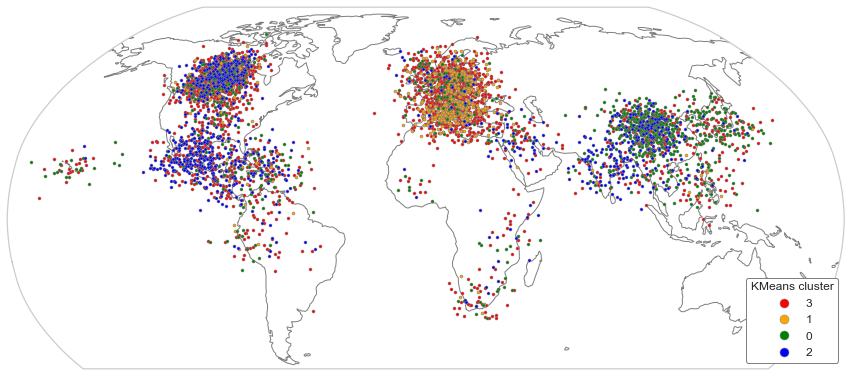

In [54]:
sns.set_theme(style='whitegrid')

fig = plt.figure(figsize=(15,8))

ax = plt.axes(projection=ccrs.Robinson())
#ax.stock_img()
ax.coastlines(color='gray')

coords = defaultdict(lambda: {'lng_coords': [], 'lat_coords': []})

for key in keys:
    for item in data[key]['geographical_tags_updated_coords']:
        for tag in item:
            coords[df_clusters.loc[key]['cluster']]['lng_coords'].append(
                    item[tag][0]['lng']
            )
            coords[df_clusters.loc[key]['cluster']]['lat_coords'].append(
                    item[tag][0]['lat']
            )

for cluster in coords:
    try:
        jittered_lng_coords = [lng + np.random.normal(0, 8) for lng in coords[cluster]['lng_coords']]
        jittered_lat_coords = [lat + np.random.normal(0, 5) for lat in coords[cluster]['lat_coords']]
    except:
        continue

    plt.plot(jittered_lng_coords, jittered_lat_coords,
            color=cluster_colors[cluster], label=cluster, linestyle='', 
                marker='o', markersize=3, markeredgewidth=0.5, markeredgecolor='gray', alpha=1, 
                transform=ccrs.Geodetic())


plt.legend(ncol=1, fontsize='medium', loc='lower right', fancybox=True, framealpha=1, facecolor='white', edgecolor='gray', markerscale=3, title='KMeans cluster')

plt.savefig(VISUALIZATION_FOLDER + 'map.png', dpi=300, bbox_inches='tight')
plt.show()